# Comparing Scores for tigge, deterministic, parametric, test-time dropout, categorical models

Todo
- run scripts for MC dropout
- in parametric, std values negative in 0.01% cases. ->make them zero.
- in categorical, 
    - instead of mean=sigma(xP), try sampling to find scores
    - see why quantile binning giving worse results than uniform
    - check if making first, last bin_edges uniform increases score.(minor thing.may skip)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import xskillscore as xs
import matplotlib.pyplot as plt
from src.data_generator import *
from src.train import *
from src.utils import *
from src.networks import *
from src.score import *

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
#limit_mem()

In [4]:
#if model was trained on mixed precision policy, loading on the same policy necessary? Yes. see verbose results of model.predict
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [5]:
model_save_dir='/home/garg/data/WeatherBench/predictions_P/saved_models'
datadir='/home/garg/data/WeatherBench/5.625deg'
pred_save_dir='/home/garg/data/WeatherBench/predictions_P'

In [6]:
#Parameters
lead_time=72
member=2

In [7]:
!ls $pred_save_dir

001-resnet_d3_ztt_3d_dr0.0.nc	  010-resnet_d3_z_3d_cat_quant.nc
003-resnet_d3_ztt_3d_dr0.2.nc	  011-resnet_d3_t_3d_cat_quant.nc
003-resnet_d3_ztt_3d_dr0.2_m2.nc  020-resnet_d3_tp_3d_dr0.0.nc
004-resnet_d3_ztt_3d_dr0.5.nc	  021-resnet_d3_tp_3d_dr0.2.nc
004-resnet_d3_ztt_3d_dr0.5_m2.nc  021-resnet_d3_tp_3d_dr0.2_m2.nc
005-resnet_d3_ztt_3d_param.nc	  022-resnet_d3_tp_3d_dr0.5.nc
006-resnet_d3_z_3d_cat.nc	  saved_models
007-resnet_d3_t_3d_cat.nc


# Data

In [39]:
!ls {datadir}

2017_2018_subset.zip	  geopotential	     toa_incident_solar_radiation
2m_temperature		  geopotential_500   u_component_of_wind
6hr_precipitation	  specific_humidity  v_component_of_wind
backup_specific_humidity  temperature
constants		  temperature_850


In [55]:
z500_valid = load_test_data(f'{datadir}/geopotential_500', 'z').drop('level')
t850_valid = load_test_data(f'{datadir}/temperature_850', 't').drop('level')
t2m_valid = xr.open_mfdataset(f'{datadir}/2m_temperature/*.nc',combine='by_coords')
tp_valid=xr.open_mfdataset(f'{datadir}/6hr_precipitation/*.nc',combine='by_coords')

ztt_valid=xr.merge([z500_valid,t850_valid, t2m_valid]).rename({'z':'z_500', 't':'t_850'})
valid=xr.merge([ztt_valid, tp_valid])
valid

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17520)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Data variables:
    z_500    (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    t_850    (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    tp       (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>

In [56]:
# dr=0.1 missing.
# exp_id='001-resnet_d3_ztt_3d_dr0.0'
# dr00_ztt_preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

#exp_id='002-resnet_d3_ztt_3d_dr0.1'
#dr01_preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

# exp_id='003-resnet_d3_ztt_3d_dr0.2'
# dr02_ztt_preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}_m{member}.nc').rename({'z':'z_500','t':'t_850'})

# exp_id='004-resnet_d3_ztt_3d_dr0.5'
# dr05_ztt_preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

# exp_id='005-resnet_d3_ztt_3d_param'
# param_ztt_preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

exp_id='006-resnet_d3_z_3d_cat'
cat_z_preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

exp_id='007-resnet_d3_t_3d_cat'
cat_t_preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')
#t2m missing, p missing.
# exp_id='010-resnet_d3_z_3d_cat_quant'
# cat_quant_z_preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

# exp_id='011-resnet_d3_t_3d_cat_quant'
# cat_quant_t_preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

# exp_id='020-resnet_d3_tp_3d_dr0.0'
# dr00_tp_preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

# exp_id='021-resnet_d3_tp_3d_dr0.2'
# dr02_tp_preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}_m{member}.nc')

# exp_id='022-resnet_d3_tp_3d_dr0.5'
# dr05_tp_preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

In [11]:
#param_ztt_preds

In [12]:
#dr02_ztt_preds, dr02_tp_preds

In [13]:
#cat_z_preds
#cat_quant_z_preds.z

# Monte-carlo dropout

In [11]:
!ls {pred_save_dir}

001-resnet_d3_ztt_3d_dr0.0.nc	  010-resnet_d3_z_3d_cat_quant.nc
003-resnet_d3_ztt_3d_dr0.2.nc	  011-resnet_d3_t_3d_cat_quant.nc
003-resnet_d3_ztt_3d_dr0.2_m2.nc  020-resnet_d3_tp_3d_dr0.0.nc
004-resnet_d3_ztt_3d_dr0.5.nc	  021-resnet_d3_tp_3d_dr0.2.nc
004-resnet_d3_ztt_3d_dr0.5_m2.nc  021-resnet_d3_tp_3d_dr0.2_m2.nc
005-resnet_d3_ztt_3d_param.nc	  022-resnet_d3_tp_3d_dr0.5.nc
006-resnet_d3_z_3d_cat.nc	  saved_models
007-resnet_d3_t_3d_cat.nc


In [18]:
#Ask- Please run for 100. (for each- ztt, tp, for each- dr 0.1,0.2, dr 0.5)
member=2

exp_id_path='/home/garg/WeatherBench/nn_configs/P/004-resnet_d3_ztt_3d_dr0.5.yml'
args=load_args(exp_id_path)
args['model_save_dir']=model_save_dir
args['datadir']=datadir
args['pred_save_dir']=pred_save_dir

print('python create_dropout_ensemble.py ',member,"'"+exp_id_path+"' '"+datadir+"' '"+model_save_dir+"' '"+pred_save_dir+"'", ' no_mean=False old_const=False')

#For precipitation, no_mean=True
#!python create_dropout_ensemble.py 2 {exp_id_path} {datadir} {model_save_dir} {pred_save_dir} no_mean=True old_const=False

python create_dropout_ensemble.py  2 '/home/garg/WeatherBench/nn_configs/P/004-resnet_d3_ztt_3d_dr0.5.yml' '/home/garg/data/WeatherBench/5.625deg' '/home/garg/data/WeatherBench/predictions_P/saved_models' '/home/garg/data/WeatherBench/predictions_P'  no_mean=False old_const=False


In [23]:
# preds=xr.open_dataset(f'{pred_save_dir}/{args["exp_id"]}_m2.nc')
# preds

In [20]:
preds=xr.merge([dr02_ztt_preds, dr02_tp_preds])
preds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, member: 2, time: 17436)
Coordinates:
  * member   (member) int64 0 1
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    t2m      (member, time, lat, lon) float64 ...
    t_850    (member, time, lat, lon) float64 ...
    z_500    (member, time, lat, lon) float64 ...
    tp       (member, time, lat, lon) float64 ...

In [21]:
valid

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17520)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Data variables:
    z_500    (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    t_850    (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    tp       (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>

In [37]:
#RMSE
ens_mean=preds.mean('member')
dr02_rmse=compute_weighted_rmse(ens_mean,valid)
dr02_rmse.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 1.665
    t_850    float64 1.928
    z_500    float64 341.7
    tp       float64 0.002167

In [38]:
#Spread-Skill
dr02_spread=compute_weighted_meanspread(preds)
dr02_spreadskill=dr02_spread/dr02_rmse
dr02_spreadskill.load() #pretty bad

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 0.298
    t_850    float64 0.257
    z_500    float64 0.3045
    tp       float64 0.08413

In [40]:
#CRPS
dr02_crps=compute_weighted_crps(preds, valid.sel(time=preds.time))
dr02_crps.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 191.8
    t_850    float64 1.222
    t2m      float64 0.9523
    tp       float64 0.0006109

In [26]:
#Rank Histogram
pred=preds
pred=pred.isel(time=slice(0,20))#or slice members. #Ask- Run Full. Only a subset possible. too slow.
obs=valid.sel(time=preds.time)
obs = obs.chunk({'time': 500})
pred=pred.chunk({'time':500})
#Ques: doesnt help much. still unable to run rank-histogram on full data due to memory error.

from ranky import rankz

mask=np.ones(obs.z_500.values.shape) #useless. #masked where 0/false.
result_z_500 = rankz(obs.z_500.values, preds.z_500.values, mask)
result_t_850 = rankz(obs.t_850.values, preds.z_500.values, mask)
result_t2m = rankz(obs.t2m.values, preds.z_500.values, mask)
result_tp = rankz(obs.tp.values, preds.z_500.values, mask)

KeyboardInterrupt: 

In [ ]:
fig, axs=plt.subplots(2,2)
axs[0,0].bar(range(1,pred.z_500.values.shape[0]+2), result_z[0])
axs[0,1].bar(range(1,pred.t_850.values.shape[0]+2), result_t[0])
axs[1,0].bar(range(1,pred.t2m.values.shape[0]+2), result_t2m[0])
axs[1,1].bar(range(1,pred.tp.values.shape[0]+2), result_tp[0])

# Parametric

In [14]:
param_ztt_preds=param_ztt_preds.rename({'z-mean':'z_mean','z-std':'z_std', 't-mean':'t_mean', 't-std':'t_std','t2m-mean':'t2m_mean','t2m-std':'t2m_std'})
param_ztt_preds

<xarray.Dataset>
Dimensions:   (lat: 32, lon: 64, time: 17388)
Coordinates:
  * time      (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-29T23:00:00
  * lat       (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon       (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    t2m_std   (time, lat, lon) float64 ...
    z_mean    (time, lat, lon) float64 ...
    z_std     (time, lat, lon) float64 ...
    t_std     (time, lat, lon) float64 ...
    t2m_mean  (time, lat, lon) float64 ...
    t_mean    (time, lat, lon) float64 ...

In [16]:
#Ask: 0.014% values of std are -ve. Changing to absolute for now.
a=param_ztt_preds.z_std.where(param_ztt_preds.z_std<0).values
print(np.count_nonzero(~np.isnan(a))*100/a.size)
#change to zero.
param_ztt_preds['z_std']=param_ztt_preds.z_std.where(param_ztt_preds.z_std>0,0)
param_ztt_preds['t_std']=param_ztt_preds.t_std.where(param_ztt_preds.t_std>0,0)
param_ztt_preds['t2m_std']=param_ztt_preds.t2m_std.where(param_ztt_preds.t2m_std>0,0)

0.01453779636099609


In [18]:
param_ztt_preds_mean=param_ztt_preds[['z_mean','t_mean','t2m_mean']].rename({'z_mean':'z_500','t_mean':'t_850','t2m_mean':'t2m'})
param_ztt_preds_std=param_ztt_preds[['z_std','t_std','t2m_std']].rename({'z_std':'z_500','t_std':'t_850','t2m_std':'t2m'})

In [19]:
print(param_ztt_preds_mean.z_500.isel(lat=0,lon=0,time=0).values, param_ztt_preds_mean.t_850.isel(lat=0,lon=0,time=0).values, param_ztt_preds_mean.t2m.isel(lat=0,lon=0,time=0).values)
print(param_ztt_preds_std.z_500.isel(lat=0,lon=0,time=0).values, param_ztt_preds_std.t_850.isel(lat=0,lon=0,time=0).values, param_ztt_preds_std.t2m.isel(lat=0,lon=0,time=0).values)

51156.67786528251 257.3167883721469 248.26674222538108
319.78635102035287 1.1886433908207181 1.8425003027575264


In [20]:
#RMSE
param_ztt_rmse=compute_weighted_rmse(param_ztt_preds_mean, ztt_valid)
param_ztt_rmse.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 341.2
    t_850    float64 1.892
    t2m      float64 1.598

In [21]:
#Ask-Spread-skill. !Weighting is done after square root.
var1=param_ztt_preds_std
var1=param_ztt_preds_std*param_ztt_preds_std
weights_lat = np.cos(np.deg2rad(var1.lat))
weights_lat /= weights_lat.mean()
param_ztt_spread= np.sqrt((var1*weights_lat).mean())
param_ztt_spread

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 212.9
    t_850    float64 1.471
    t2m      float64 1.306

In [22]:
#spread-skill
param_ztt_spreadskill=param_ztt_spread/param_ztt_rmse
param_ztt_spreadskill

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 0.624
    t_850    float64 0.7778
    t2m      float64 0.8176

In [23]:
def compute_weighted_crps_gaussian(obs, mean, std,mean_dims=xr.ALL_DIMS):
    weights_lat = np.cos(np.deg2rad(obs.lat)).values
    weights_lat /= weights_lat.mean()
    crps = xs.crps_gaussian(obs,mean,std)
    crps = (crps * weights_lat[None, : , None]).mean(mean_dims)
    return crps

In [24]:
#Ask-CRPS. don't know where division by zero. Also scores look worse (another network had 134 for z)
param_ztt_crps=compute_weighted_crps_gaussian(ztt_valid.sel(time=param_ztt_preds.time), 
                                    param_ztt_preds_mean, param_ztt_preds_std)
param_ztt_crps.load()

/home/garg/miniconda3/envs/weatherbench/lib/python3.6/site-packages/properscoring/_crps.py:66: RuntimeWarning: divide by zero encountered in true_divide
  sx = (x - mu) / sig
/home/garg/miniconda3/envs/weatherbench/lib/python3.6/site-packages/properscoring/_crps.py:72: RuntimeWarning: invalid value encountered in multiply
  crps = sig * (sx * (2 * cdf - 1) + 2 * pdf - pi_inv)


<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 151.2
    t_850    float64 0.9169
    t2m      float64 0.6883

In [25]:
#Rank Histogram
#members=10
#Taking random samples from a gaussian and making an ensemble (Will have to use another method for precipitation)

z_500=xr.DataArray(np.random.normal(param_ztt_preds.z_mean.values, param_ztt_preds.z_std.values,
                                    size=(member,param_ztt_preds.z_mean.shape[0],
                                         param_ztt_preds.z_mean.shape[1],
                                         param_ztt_preds.z_mean.shape[2])),
                     coords={'member': np.arange(member),
                             'time': param_ztt_preds.time,
                             'lat': param_ztt_preds.lat, 'lon': param_ztt_preds.lon,}, 
                     dims=['member','time','lat', 'lon'])

t_850=xr.DataArray(np.random.normal(param_ztt_preds.t_mean.values, param_ztt_preds.t_std.values,
                                    size=(member,param_ztt_preds.t_mean.shape[0],
                                         param_ztt_preds.t_mean.shape[1],
                                         param_ztt_preds.t_mean.shape[2])),
                     coords={'member': np.arange(member),
                             'time': param_ztt_preds.time,
                             'lat': param_ztt_preds.lat, 'lon': param_ztt_preds.lon,}, 
                     dims=['member','time','lat', 'lon'])

t2m=xr.DataArray(np.random.normal(param_ztt_preds.t2m_mean.values, param_ztt_preds.t2m_std.values,
                                    size=(member,param_ztt_preds.t2m_mean.shape[0],
                                         param_ztt_preds.t2m_mean.shape[1],
                                         param_ztt_preds.t2m_mean.shape[2])),
                     coords={'member': np.arange(member),
                             'time': param_ztt_preds.time,
                             'lat': param_ztt_preds.lat, 'lon': param_ztt_preds.lon,}, 
                     dims=['member','time','lat', 'lon'])



preds_new=xr.Dataset()
preds_new['z_500']=z_500
preds_new['t_850']=t_850
preds_new['t2m']=t2m
preds_new

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, member: 2, time: 17388)
Coordinates:
  * member   (member) int64 0 1
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-29T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_500    (member, time, lat, lon) float64 5.079e+04 5.126e+04 ... 4.931e+04
    t_850    (member, time, lat, lon) float64 257.3 258.1 255.5 ... 261.8 255.3
    t2m      (member, time, lat, lon) float64 250.1 249.1 249.4 ... 252.2 252.6

In [26]:
#Rank Histogram
pred=preds_new
pred=pred.isel(time=slice(0,20))#or slice members. #Ask- Run Full. Only a subset possible. too slow.
obs=ztt_valid.sel(time=pred.time)
obs = obs.chunk({'time': 500})
pred=pred.chunk({'time':500})
#Ques: doesnt help much. still unable to run rank-histogram on full data due to memory error.

from ranky import rankz

#for z_500
mask=np.ones(obs.z_500.values.shape) #useless. #masked where 0/false.
result_z = rankz(obs.z_500.values, pred.z_500.values, mask)
result_t = rankz(obs.t_850.values, pred.t_850.values, mask)
result_t2m = rankz(obs.t2m.values, pred.t2m.values, mask)
#result_tp = rankz(obs.tp.values, pred.tp.values, mask)

<BarContainer object of 3 artists>

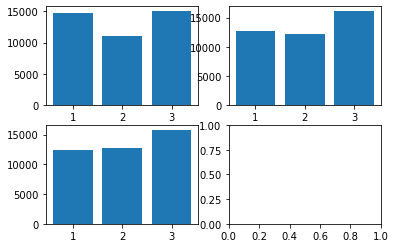

In [38]:
fig, axs=plt.subplots(2,2)
axs[0,0].bar(range(1,pred.z_500.values.shape[0]+2), result_z[0])
axs[0,1].bar(range(1,pred.t_850.values.shape[0]+2), result_t[0])
axs[1,0].bar(range(1,pred.t2m.values.shape[0]+2), result_t2m[0])
#axs[1,1].bar(range(1,pred.tp.values.shape[0]+2), result_tp[0])




# Categorical

In [57]:
cat_zt_preds=xr.merge([cat_z_preds, cat_t_preds]).rename({'z':'z_500','t':'t_850'})
cat_zt_preds

<xarray.Dataset>
Dimensions:  (bin: 50, lat: 32, lon: 64, time: 17436)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * bin      (bin) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Data variables:
    z_500    (time, lat, lon, bin) float32 ...
    t_850    (time, lat, lon, bin) float32 ...

In [43]:
cat_zt_preds.z_500 # a little different time-number from parametric, dropout
#from values it seems that this is 'predict_difference' method

<xarray.DataArray 'z_500' (time: 17436, lat: 32, lon: 64, bin: 50)>
[1785446400 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * bin      (bin) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Attributes:
    bin_edges:   [          -inf -4811.67512001 -4611.18865667 -4410.70219334...
    mid_points:  [          -inf -4711.43188834 -4510.94542501 -4310.45896167...
    bin_width:   inf

In [44]:
cat_zt_preds.z_500.isel(time=0,lat=0,lon=0).values.sum() #probabilities outputted

1.000139

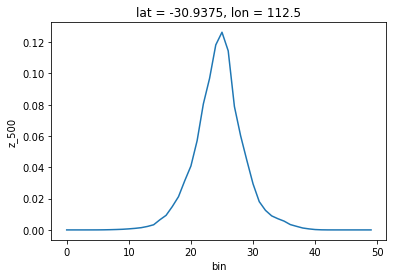

In [45]:
cat_zt_preds.z_500.isel(lat=10, lon=20).mean('time').plot()

In [94]:
#Valid data
zt_valid=xr.merge([z500_valid,t850_valid]).rename({'z':'z_500', 't':'t_850'})
zt_valid_diff = (zt_valid.shift() - zt_valid.shift(time=lead_time)).dropna('time')
zt_valid_diff #time size changes.

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17448)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-04 ... 2018-12-31T23:00:00
Data variables:
    z_500    (time, lat, lon) float32 dask.array<chunksize=(8688, 32, 64), meta=np.ndarray>
    t_850    (time, lat, lon) float32 dask.array<chunksize=(8688, 32, 64), meta=np.ndarray>

In [59]:
#we should change -inf, inf to some finite values
cat_zt_preds.z_500.bin_edges[0]=zt_valid_diff.z_500.min().values
cat_zt_preds.z_500.bin_edges[-1]=zt_valid_diff.z_500.max().values
cat_zt_preds.t_850.bin_edges[0]=zt_valid_diff.t_850.min().values
cat_zt_preds.t_850.bin_edges[-1]=zt_valid_diff.t_850.min().values

cat_zt_preds.z_500.mid_points[0]=cat_zt_preds.z_500.bin_edges[1]-0.5*(cat_zt_preds.z_500.bin_edges[1]-cat_zt_preds.z_500.bin_edges[0])
cat_zt_preds.z_500.mid_points[-1]=cat_zt_preds.z_500.bin_edges[-2]+0.5*(cat_zt_preds.z_500.bin_edges[-1]-cat_zt_preds.z_500.bin_edges[-2])
cat_zt_preds.t_850.mid_points[0]=cat_zt_preds.t_850.bin_edges[1]-0.5*(cat_zt_preds.t_850.bin_edges[1]-cat_zt_preds.t_850.bin_edges[0])
cat_zt_preds.t_850.mid_points[-1]=cat_zt_preds.t_850.bin_edges[-2]+0.5*(cat_zt_preds.t_850.bin_edges[-1]-cat_zt_preds.t_850.bin_edges[-2])

#Ask- Unable to set bin-width as a  (50,1) array. doesnt matter. doesnt impact crps calculation.one solution is to take first and last bins as uniform and not min/max
#cat_zt_preds.z_500.bin_width=(cat_zt_preds.z_500.bin_edges[1:]-cat_zt_preds.z_500.bin_edges[:-1])

In [60]:
cat_zt_preds.z_500

<xarray.DataArray 'z_500' (time: 17436, lat: 32, lon: 64, bin: 50)>
[1785446400 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * bin      (bin) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Attributes:
    bin_edges:   [-7296.640625   -4811.67512001 -4611.18865667 -4410.70219334...
    mid_points:  [-6054.1578725  -4711.43188834 -4510.94542501 -4310.45896167...
    bin_width:   inf

In [61]:
#For RMSE1- most likely class. But we lose all probability info.
# Using bin mid_points of prediction with highest probability
das = []
for var in ['z_500', 't_850']:
    idxs = np.argmax(cat_zt_preds[var], -1)
    most_likely = cat_zt_preds[var].mid_points[idxs]
    das.append(xr.DataArray(
        most_likely, dims=['time', 'lat', 'lon'],
        coords = [cat_zt_preds.time, cat_zt_preds.lat, cat_zt_preds.lon],
        name=var
    ))
preds_ml = xr.merge(das)
#preds_ml

In [62]:
preds_ml.z_500.mean().values, zt_valid_diff.z_500.mean().values

(array(15.22428736), array(-0.6240898, dtype=float32))

In [19]:
zt_cat_rmse=compute_weighted_rmse(preds_ml, zt_valid_diff.sel(time=preds_ml.time))
zt_cat_rmse.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 383.5
    t_850    float64 2.174

In [63]:
#Correct way. RMSE= ∑xP
aa=preds_ml.z_500.isel(time=0, lat=0,lon=0); print('most likely', aa.values)

ab=cat_zt_preds.z_500.isel(time=0, lat=0, lon=0);ab.values
ac=cat_zt_preds.z_500.mid_points; ac
ad=ab*ac; ad
print('mean',ad.sum().values)

most likely -100.24323166678825
mean -101.60616834764451


In [109]:
#Ask- Unable to run full. kernel dies.
ensemble_mean=xr.Dataset()
preds=cat_zt_preds.isel(time=slice(0,20))
z_500_ensemble=(preds.z_500*preds.z_500.mid_points).sum('bin')
t_850_ensemble=(preds.t_850*preds.t_850.mid_points).sum('bin')

ensemble_mean['z_500']=z_500_ensemble
ensemble_mean['t_850']=t_850_ensemble
ensemble_mean

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 20)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2017-01-05T07:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_500    (time, lat, lon) float64 -101.6 -105.7 -102.0 ... -906.8 -903.0
    t_850    (time, lat, lon) float64 0.3607 0.2566 0.2119 ... -3.17 -3.029

In [110]:
zt_cat_rmse=compute_weighted_rmse(ensemble_mean, 
                                 zt_valid_diff.sel(
                                     time=ensemble_mean.time)).load()
zt_cat_rmse

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 410.3
    t_850    float64 2.009

In [111]:
compute_weighted_rmse(preds_ml.isel(time=slice(0,20)),zt_valid_diff.isel(time=slice(0,20))).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 447.3
    t_850    float64 2.186

In [112]:
#Correct RMSE= ∑xP
ensemble_mean

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 20)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2017-01-05T07:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_500    (time, lat, lon) float64 -101.6 -105.7 -102.0 ... -906.8 -903.0
    t_850    (time, lat, lon) float64 0.3607 0.2566 0.2119 ... -3.17 -3.029

In [113]:
#Spread=squareroot( ∑((x−μ)^2)P(x)) or E[x^2]-(E[x])^2
preds=cat_zt_preds.isel(time=slice(0,20))
obs=zt_valid_diff.sel(time=preds.time)
predssquare=preds
predssquare.z_500.attrs['mid_points']=preds.z_500.attrs['mid_points']*preds.z_500.attrs['mid_points']
predssquare.t_850.attrs['mid_points']=preds.t_850.attrs['mid_points']*preds.t_850.attrs['mid_points']

#predssquare.z_500

#Ask- Unable to run full. kernel dies.
ensemble_meansquare=xr.Dataset()
z_500_ensemble=(predssquare.z_500*predssquare.z_500.mid_points).sum('bin')
t_850_ensemble=(predssquare.t_850*predssquare.t_850.mid_points).sum('bin')

ensemble_meansquare['z_500']=z_500_ensemble
ensemble_meansquare['t_850']=t_850_ensemble
#ensemble_meansquare

#Spread
var1=ensemble_meansquare-ensemble_mean*ensemble_mean
weights_lat = np.cos(np.deg2rad(var1.lat))
weights_lat /= weights_lat.mean()
zt_cat_spread= np.sqrt((var1*weights_lat).mean())
zt_cat_spread

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 314.0
    t_850    float64 1.759

In [114]:
#Spread-skill
z_cat_spreadskill=zt_cat_spread/zt_cat_rmse
z_cat_spreadskill.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 0.7653
    t_850    float64 0.8752

In [37]:
# # Bin CRPS
obs=zt_valid_diff.sel(time=cat_zt_preds.time)
preds=cat_zt_preds
zt_cat_bin_crps=compute_weighted_bin_crps(preds, obs)
zt_cat_bin_crps.load()

100%|██████████| 175/175 [01:15<00:00,  2.33it/s]


<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 162.9
    t_850    float64 0.9445

In [100]:
#Rank Histogram
member=20
preds=cat_zt_preds.isel(time=slice(0,20))
obs=zt_valid_diff.sel(time=preds.time)

z_bin_mids=preds.z_500.mid_points
t_bin_mids=preds.t_850.mid_points
preds_z=np.asarray(preds.z_500).reshape(-1,50)
preds_t=np.asarray(preds.t_850).reshape(-1,50)

preds_znew=[]
preds_tnew=[]
for i, p in enumerate(preds_z):
    prob_z=preds_z[i,:]; prob_t=preds_t[i,:]
    prob_z /= prob_z.sum();prob_t /= prob_t.sum()  #normalizing. bcoz sometimes prob doesn't equal exactly 1.
    sample_z=np.random.choice(z_bin_mids, size=member, p=preds_z[i,:],replace=True)
    sample_t=np.random.choice(t_bin_mids, size=member, p=preds_t[i,:],replace=True)
    preds_znew.append(sample_z)
    preds_tnew.append(sample_t)
    
preds_znew=np.array(preds_znew).reshape(member, -1)
preds_tnew=np.array(preds_tnew).reshape(member, -1)

In [101]:
#Rank Histogram
from ranky import rankz
obs_z=obs.z_500.values.reshape(-1)
obs_t=obs.t_850.values.reshape(-1)
# obs_t2m=obs.t2m.values.reshape(-1)
# obs_p=obs.tp.values.reshape(-1)


#for z_500
mask=np.ones(obs_z.shape) #useless. #masked where 0/false.
result_z = rankz(obs_z, preds_znew, mask)
result_t = rankz(obs_t, preds_tnew, mask)
# result_t2m = rankz(obs_z, preds_znew, mask)
# result_tp = rankz(obs_z, preds_znew, mask)

<BarContainer object of 21 artists>

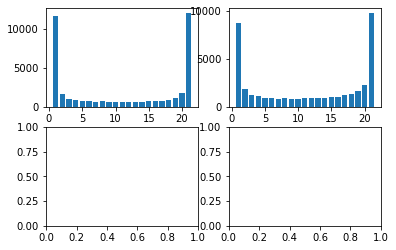

In [102]:
fig, axs=plt.subplots(2,2)
axs[0,0].bar(range(1,preds_znew.shape[0]+2), result_z[0])
axs[0,1].bar(range(1,preds_tnew.shape[0]+2), result_t[0])
#axs[1,0].bar(range(1,pred.t2m.values.shape[0]+2), result_t2m[0])
#axs[1,1].bar(range(1,pred.tp.values.shape[0]+2), result_tp[0])


In [103]:
#For RMSE3 -via sampling
shape_obs=obs.z_500.values.shape
preds_znew=preds_znew.reshape(shape_obs[0],shape_obs[1], shape_obs[2],member)
preds_tnew=preds_tnew.reshape(shape_obs[0],shape_obs[1], shape_obs[2],member)

In [104]:
preds_znew.shape

(20, 32, 64, 20)

In [105]:
preds_new=xr.Dataset()
z_500=xr.DataArray(preds_znew, dims=['time', 'lat', 'lon','member'],
        coords = {'time': preds.time, 'lat': preds.lat, 'lon': preds.lon,
                'member':np.arange(member)},)
t_850=xr.DataArray(preds_tnew, dims=['time', 'lat', 'lon','member'],
        coords = {'time': preds.time, 'lat': preds.lat, 'lon': preds.lon,
                'member':np.arange(member)},)


preds_new['z_500']=z_500
preds_new['t_850']=t_850
preds_new

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, member: 20, time: 20)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2017-01-05T07:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    z_500    (time, lat, lon, member) float64 -100.2 100.2 ... -701.7 -1.303e+03
    t_850    (time, lat, lon, member) float64 -2.369 -0.4738 ... 0.4738 -0.4738

In [106]:
#RMSE
zt_cat_rmse=compute_weighted_rmse(preds_new, zt_valid_diff.sel(time=preds_new.time))
zt_cat_rmse.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 516.9
    t_850    float64 2.671

In [107]:
zt_cat_spread=compute_weighted_meanspread(preds_new)
zt_cat_spreadskill=zt_cat_spread/zt_cat_rmse
zt_cat_spreadskill.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 0.5914
    t_850    float64 0.6424

In [108]:
zt_cat_crps=compute_weighted_crps(preds_new, zt_valid_diff.sel(time=preds_new.time))
zt_cat_crps.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 195.8
    t_850    float64 1.055

# Quantile-bins categorical

In [17]:
cat_zt_preds=xr.merge([cat_quant_z_preds, cat_quant_t_preds]).rename({'z':'z_500','t':'t_850'})
cat_zt_preds

<xarray.Dataset>
Dimensions:  (bin: 50, lat: 32, lon: 64, time: 17436)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * bin      (bin) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Data variables:
    z_500    (time, lat, lon, bin) float32 ...
    t_850    (time, lat, lon, bin) float32 ...

In [18]:
cat_zt_preds.z_500 # a little different time-number from parametric, dropout
#from values it seems that this is 'predict_difference' method

<xarray.DataArray 'z_500' (time: 17436, lat: 32, lon: 64, bin: 50)>
[1785446400 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * bin      (bin) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Attributes:
    bin_edges:   [          -inf -2485.59762537 -2040.21876359 -1771.66673765...
    mid_points:  [          -inf -2262.90819448 -1905.94275062 -1658.69273963...
    bin_width:   inf

In [19]:
cat_zt_preds.z_500.isel(time=0,lat=0,lon=0).values.sum() #probabilities outputted

0.9999856

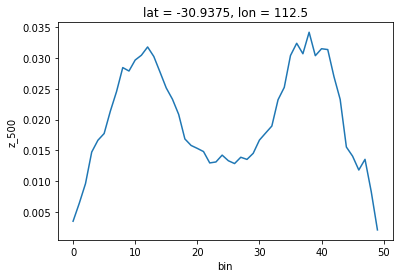

In [22]:
cat_zt_preds.z_500.isel(lat=10, lon=20).mean('time').plot() #bi-modal !!

In [23]:
#Valid data
zt_valid=xr.merge([z500_valid,t850_valid]).rename({'z':'z_500', 't':'t_850'})
zt_valid_diff = (zt_valid.shift() - zt_valid.shift(time=lead_time)).dropna('time')
zt_valid_diff #time size changes.

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17448)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-04 ... 2018-12-31T23:00:00
Data variables:
    z_500    (time, lat, lon) float32 dask.array<chunksize=(8688, 32, 64), meta=np.ndarray>
    t_850    (time, lat, lon) float32 dask.array<chunksize=(8688, 32, 64), meta=np.ndarray>

In [24]:
#we should change -inf, inf to some finite values
cat_zt_preds.z_500.bin_edges[0]=zt_valid_diff.z_500.min().values
cat_zt_preds.z_500.bin_edges[-1]=zt_valid_diff.z_500.max().values
cat_zt_preds.t_850.bin_edges[0]=zt_valid_diff.t_850.min().values
cat_zt_preds.t_850.bin_edges[-1]=zt_valid_diff.t_850.min().values

cat_zt_preds.z_500.mid_points[0]=cat_zt_preds.z_500.bin_edges[1]-0.5*(cat_zt_preds.z_500.bin_edges[1]-cat_zt_preds.z_500.bin_edges[0])
cat_zt_preds.z_500.mid_points[-1]=cat_zt_preds.z_500.bin_edges[-2]+0.5*(cat_zt_preds.z_500.bin_edges[-1]-cat_zt_preds.z_500.bin_edges[-2])
cat_zt_preds.t_850.mid_points[0]=cat_zt_preds.t_850.bin_edges[1]-0.5*(cat_zt_preds.t_850.bin_edges[1]-cat_zt_preds.t_850.bin_edges[0])
cat_zt_preds.t_850.mid_points[-1]=cat_zt_preds.t_850.bin_edges[-2]+0.5*(cat_zt_preds.t_850.bin_edges[-1]-cat_zt_preds.t_850.bin_edges[-2])

#Ask- Unable to set bin-width as a  (50,1) array. doesnt matter. doesnt impact crps calculation.one solution is to take first and last bins as uniform and not min/max
#cat_zt_preds.z_500.bin_width=(cat_zt_preds.z_500.bin_edges[1:]-cat_zt_preds.z_500.bin_edges[:-1])

In [25]:
cat_zt_preds.z_500

<xarray.DataArray 'z_500' (time: 17436, lat: 32, lon: 64, bin: 50)>
[1785446400 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * bin      (bin) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Attributes:
    bin_edges:   [-7.29664062e+03 -2.48559763e+03 -2.04021876e+03 -1.77166674...
    mid_points:  [-4.89111913e+03 -2.26290819e+03 -1.90594275e+03 -1.65869274...
    bin_width:   inf

In [26]:
#For RMSE1- most likely class. But we lose all probability info.
# Using bin mid_points of prediction with highest probability
das = []
for var in ['z_500', 't_850']:
    idxs = np.argmax(cat_zt_preds[var], -1)
    most_likely = cat_zt_preds[var].mid_points[idxs]
    das.append(xr.DataArray(
        most_likely, dims=['time', 'lat', 'lon'],
        coords = [cat_zt_preds.time, cat_zt_preds.lat, cat_zt_preds.lon],
        name=var
    ))
preds_ml = xr.merge(das)
preds_ml

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17436)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_500    (time, lat, lon) float64 -548.5 -548.5 ... -1.447e+03 -1.447e+03
    t_850    (time, lat, lon) float64 -1.057 -1.731 -1.731 ... -6.546 -9.288

In [27]:
preds_ml.z_500.mean().values, zt_valid_diff.z_500.mean().values

(array(-154.42724882), array(-0.6240898, dtype=float32))

In [28]:
zt_cat_rmse=compute_weighted_rmse(preds_ml, zt_valid_diff.sel(time=preds_ml.time))
zt_cat_rmse.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 619.2
    t_850    float64 4.586

In [29]:
#Correct way. RMSE= ∑xP
aa=preds_ml.z_500.isel(time=0, lat=0,lon=0); print(aa.values)

ab=cat_zt_preds.z_500.isel(time=0, lat=0, lon=0);ab.values
ac=cat_zt_preds.z_500.mid_points; ac
ad=ab*ac; ad
ad.sum().values

-548.5331986033314


array(-467.04123775)

In [31]:
#Ask- Unable to run full. kernel dies.
preds=cat_zt_preds.isel(time=slice(0,20))
ensemble_mean=xr.Dataset()

z_500_ensemble=(preds.z_500*preds.z_500.mid_points).sum('bin')
t_850_ensemble=(preds.t_850*preds.t_850.mid_points).sum('bin')

ensemble_mean['z_500']=z_500_ensemble
ensemble_mean['t_850']=t_850_ensemble
ensemble_mean

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 20)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2017-01-05T07:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_500    (time, lat, lon) float64 -467.0 -508.0 ... -1.654e+03 -1.645e+03
    t_850    (time, lat, lon) float64 -0.281 -0.5851 -0.8576 ... -1.554 -1.21

In [32]:
zt_cat_rmse=compute_weighted_rmse(ensemble_mean, 
                                 zt_valid_diff.sel(
                                     time=ensemble_mean.time)).load()
zt_cat_rmse

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 454.4
    t_850    float64 2.962

In [33]:
compute_weighted_rmse(preds_ml.isel(time=slice(0,20)),zt_valid_diff.isel(time=slice(0,20))).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 586.6
    t_850    float64 3.974

In [46]:
#Correct RMSE= ∑xP
ensemble_mean

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 20)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2017-01-05T07:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_500    (time, lat, lon) float64 -101.6 -105.7 -102.0 ... -906.8 -903.0
    t_850    (time, lat, lon) float64 0.3607 0.2566 0.2119 ... -3.17 -3.029

In [34]:
#Spread=squareroot( ∑((x−μ)^2)P(x)) or E[x^2]-(E[x])^2
preds=cat_zt_preds.isel(time=slice(0,20))


obs=zt_valid_diff.sel(time=preds.time)
predssquare=preds
predssquare.z_500.attrs['mid_points']=preds.z_500.attrs['mid_points']*preds.z_500.attrs['mid_points']
predssquare.t_850.attrs['mid_points']=preds.t_850.attrs['mid_points']*preds.t_850.attrs['mid_points']

In [35]:
#predssquare.z_500

In [36]:
#Ask- Unable to run full. kernel dies.
ensemble_meansquare=xr.Dataset()
z_500_ensemble=(predssquare.z_500*predssquare.z_500.mid_points).sum('bin')
t_850_ensemble=(predssquare.t_850*predssquare.t_850.mid_points).sum('bin')

ensemble_meansquare['z_500']=z_500_ensemble
ensemble_meansquare['t_850']=t_850_ensemble
#ensemble_meansquare

In [37]:
#Spread
var1=ensemble_meansquare-ensemble_mean*ensemble_mean #Wrong. has -ve t values
weights_lat = np.cos(np.deg2rad(var1.lat))
weights_lat /= weights_lat.mean()
zt_cat_spread= np.sqrt((var1*weights_lat).mean())
zt_cat_spread

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 487.9
    t_850    float64 2.529

In [38]:
#Spread-skill
z_cat_spreadskill=zt_cat_spread/zt_cat_rmse
z_cat_spreadskill.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 1.074
    t_850    float64 0.8541

In [39]:
# # Bin CRPS
obs=zt_valid_diff.sel(time=cat_zt_preds.time)
preds=cat_zt_preds
zt_cat_bin_crps=compute_weighted_bin_crps(preds, obs)
zt_cat_bin_crps.load() #WRONG. Can't be negative.

100%|██████████| 175/175 [01:55<00:00,  1.52it/s]


<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 188.3
    t_850    float64 -0.01537

In [40]:
#Rank Histogram
member=20
preds=cat_zt_preds.isel(time=slice(0,20))
obs=zt_valid_diff.sel(time=preds.time)

z_bin_mids=preds.z_500.mid_points
t_bin_mids=preds.t_850.mid_points
preds_z=np.asarray(preds.z_500).reshape(-1,50)
preds_t=np.asarray(preds.t_850).reshape(-1,50)

preds_znew=[]
preds_tnew=[]
for i, p in enumerate(preds_z):
    prob_z=preds_z[i,:]; prob_t=preds_t[i,:]
    prob_z /= prob_z.sum();prob_t /= prob_t.sum()  #normalizing. bcoz sometimes prob doesn't equal exactly 1.
    sample_z=np.random.choice(z_bin_mids, size=member, p=preds_z[i,:],replace=True)
    sample_t=np.random.choice(t_bin_mids, size=member, p=preds_t[i,:],replace=True)
    preds_znew.append(sample_z)
    preds_tnew.append(sample_t)
    
preds_znew=np.array(preds_znew).reshape(member, -1)
preds_tnew=np.array(preds_tnew).reshape(member, -1)

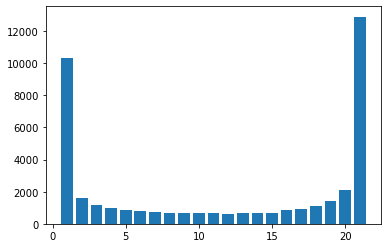

In [41]:
#Rank Histogram
from ranky import rankz
obs_z=obs.z_500.values.reshape(-1)
#for z_500
mask=np.ones(obs_z.shape) #useless. #masked where 0/false.
result = rankz(obs_z, preds_znew, mask)
plt.bar(range(1,preds_znew.shape[0]+2), result[0])
plt.show()

In [27]:
#for all

# create dropout ensemble testing

In [8]:
!ls {pred_save_dir}

001-resnet_d3_ztt_3d_dr0.0.nc	  010-resnet_d3_z_3d_cat_quant.nc
003-resnet_d3_ztt_3d_dr0.2.nc	  011-resnet_d3_t_3d_cat_quant.nc
003-resnet_d3_ztt_3d_dr0.2_m2.nc  020-resnet_d3_tp_3d_dr0.0.nc
004-resnet_d3_ztt_3d_dr0.5.nc	  021-resnet_d3_tp_3d_dr0.2.nc
004-resnet_d3_ztt_3d_dr0.5_m2.nc  021-resnet_d3_tp_3d_dr0.2_m2.nc
005-resnet_d3_ztt_3d_param.nc	  022-resnet_d3_tp_3d_dr0.5.nc
006-resnet_d3_z_3d_cat.nc	  saved_models
007-resnet_d3_t_3d_cat.nc


In [9]:
import tqdm
from tqdm import tqdm
#Somehow .py script doesn't run, but copying code here in notebook works.
#works for ztt, not for tp

In [10]:
    exp_id_path='/home/garg/WeatherBench/nn_configs/P/022-resnet_d3_tp_3d_dr0.5.yml'
    ensemble_size=2; old_const=False; no_mean=False; multi_dt=False; verbose=0
    no_mean=True; #for precipitation
    args=load_args(exp_id_path)
    args['model_save_dir']=model_save_dir
    args['pred_save_dir']=pred_save_dir
    args['datadir']=datadir

    args['ext_mean'] =xr.open_dataarray(f'{args["model_save_dir"]}/{args["exp_id"]}_mean.nc')
    args['ext_std'] = xr.open_dataarray(f'{args["model_save_dir"]}/{args["exp_id"]}_std.nc')
    dg=load_data(**args, old_const=old_const, only_test=True)

    #tf.compat.v1.disable_eager_execution() #needed
    
    model = keras.models.load_model(
    f'{args["model_save_dir"]}/{args["exp_id"]}.h5',
    custom_objects={'PeriodicConv2D': PeriodicConv2D, 'ChannelReLU2D': ChannelReLU2D, 
                   'lat_mse': tf.keras.losses.mse})
    #adding dropout
    c = model.get_config()
    for l in c['layers']:
        if l['class_name'] == 'Dropout':
            l['inbound_nodes'][0][0][-1] = {'training': True}
    
    model2 = keras.models.Model.from_config(c, custom_objects={'PeriodicConv2D': PeriodicConv2D, 'ChannelReLU2D': ChannelReLU2D, 'lat_mse': tf.keras.losses.mse})
    model2.set_weights(model.get_weights())
            
    
    level_names = dg.data.isel(level=dg.output_idxs).level_names
    level = dg.data.isel(level=dg.output_idxs).level
    
    preds = []
    for _ in tqdm(range(ensemble_size)):
        #preds.append(model2.predict(dg.tfr_dataset or dg, verbose=verbose))
        preds.append(model2.predict(dg, verbose=verbose))
    

    
    preds = np.array(preds)
    

    preds = xr.DataArray(
        preds[0] if multi_dt else preds,
        dims=['member','time', 'lat', 'lon', 'level'],
        coords={'member':np.arange(ensemble_size),'time': dg.valid_time, 'lat': dg.data.lat, 'lon': dg.data.lon,
                'level': level,
                'level_names': level_names
                },
    )
    # Unnormalize
    mean = dg.mean.isel(level=dg.output_idxs).values if not no_mean else 0
    std = dg.std.isel(level=dg.output_idxs).values
    preds = preds * std + mean
    #print(mean)
    unique_vars = list(set([l.split('_')[0] for l in preds.level_names.values]))

    # Reverse tranforms
    if hasattr(dg.mean, 'tp_log') and 'tp' in unique_vars:
        tp_idx = list(preds.level_names).index('tp')
        preds.values[..., tp_idx] = log_retrans(preds.values[..., tp_idx], dg.mean.tp_log)

    das = []
    for v in unique_vars:
        idxs = [i for i, vv in enumerate(preds.level_names.values) if vv.split('_')[0] == v]
        da = preds.isel(level=idxs).squeeze().drop('level_names')
        if not 'level' in da.dims: da = da.drop('level')
        das.append({v: da})
    preds=xr.merge(das)
    
    preds.to_netcdf(f'{args["pred_save_dir"]}/{args["exp_id"]}_m{ensemble_size}.nc')
    print(f'saved on disk in {args["pred_save_dir"]}/{args["exp_id"]}_m{ensemble_size}.nc')


  0%|          | 0/2 [00:00<?, ?it/s]


StopIteration: 

In [13]:
exp_id='004-resnet_d3_ztt_3d_dr0.5_2'
preds1=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

In [14]:
preds1

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, member: 2, time: 17436)
Coordinates:
  * member   (member) int64 0 1
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    t2m      (member, time, lat, lon) float64 ...
    z        (member, time, lat, lon) float64 ...
    t        (member, time, lat, lon) float64 ...

# Plots

In [ ]:
t2m_valid.t2m.isel(lat=10, lon =30).plot()